(Active R Kernel)

In [59]:
library("RADAR")

run_radar <- function(enz, gtf,species, cutoff = 0.1, Beta_cutoff = 0.5,threads = 18){
    outputDir = paste("radar", species,enz, sep='/')
    radar <- countReads(
        samplenames = unlist(lapply (c('s23','s24'), paste, paste(species,c('NT',enz), sep='.'),sep='.')),
        gtf = gtf,
        bamFolder = "bam",
        modification = 'm6A',
        strandToKeep = "opposite",
        outputDir = outputDir,
        threads = threads,
        saveOutput = TRUE
    )
    radar <- normalizeLibrary(radar) #, boxPlot = FALSE)
    radar <- adjustExprLevel(radar)
    variable(radar) <- data.frame( Group =data.frame( Group = rep(c("input","meRIP"),2)) )
    radar <- filterBins(radar,minCountsCutOff = 15)
    radar <- diffIP_parallel(radar, thread = threads)
    top_bins <- extractIP(radar,filtered = T)[order(rowMeans( extractIP(radar,filtered = T) ),decreasing = T)[1:1000],]
    radar <- reportResult(radar, cutoff = cutoff, Beta_cutoff = Beta_cutoff, threads=threads)
    result <- results(radar)
    saveRDS(radar, file = paste(outputDir,"radar.rds",sep='/'))
}


https://scottzijiezhang.github.io/RADARmanual/workflow.html

# run radar on human bam files 

In [55]:
gtf = "/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf"

Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 25.9279416004817 mins... 


Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 3 is not drawn”

Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
input meRIP input meRIP 
    0     1     0     1 
running PoissonGamma test at single beta mode
Hyper-thread registered: FALSE 
Using 1 thread(s) to run PoissonGamma test...


Warning message:
“executing %dopar% sequentially: no parallel backend registered”

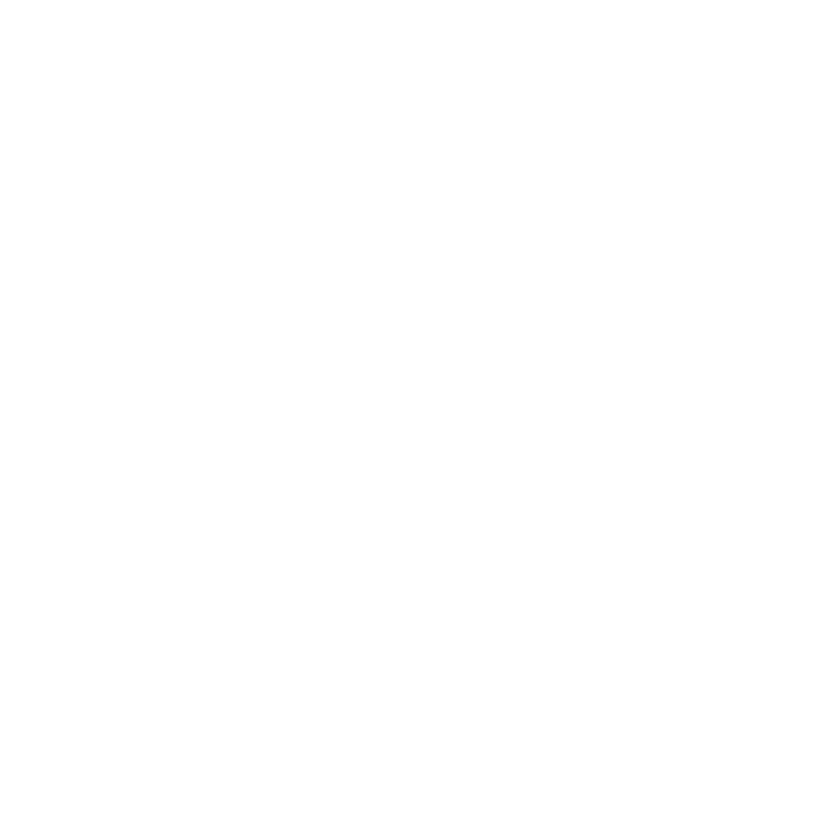

Time used to run PoissonGamma test: 3.65684252580007 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.
Hyper-thread registered: TRUE 
Using 16 thread(s) to report merged report...
Time used to report peaks: 0.664876178900401 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 5750 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


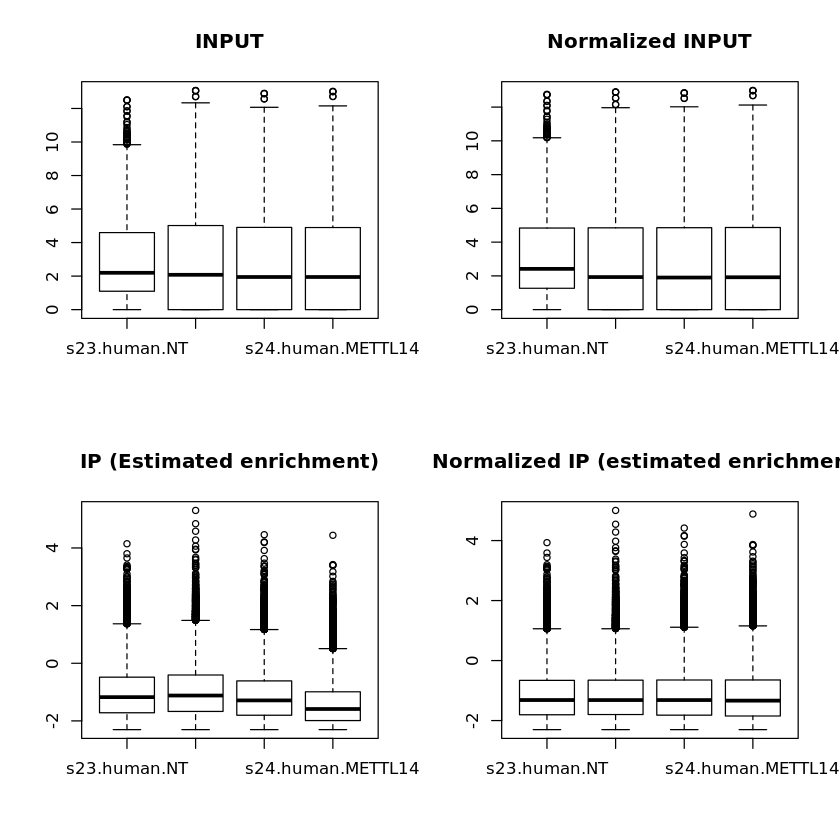

In [56]:
enz = 'METTL14'
run_radar(enz,gtf,'human')

[1] "Stage: index bam file bam/s23.human.METTL3.input.bam"
[1] "Stage: index bam file bam/s23.human.METTL3.m6A.bam"
[1] "Stage: index bam file bam/s24.human.METTL3.input.bam"
[1] "Stage: index bam file bam/s24.human.METTL3.m6A.bam"
Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 24.6841977715492 mins... 


Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 1 is not drawn”Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 3 is not drawn”Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 4 is not drawn”

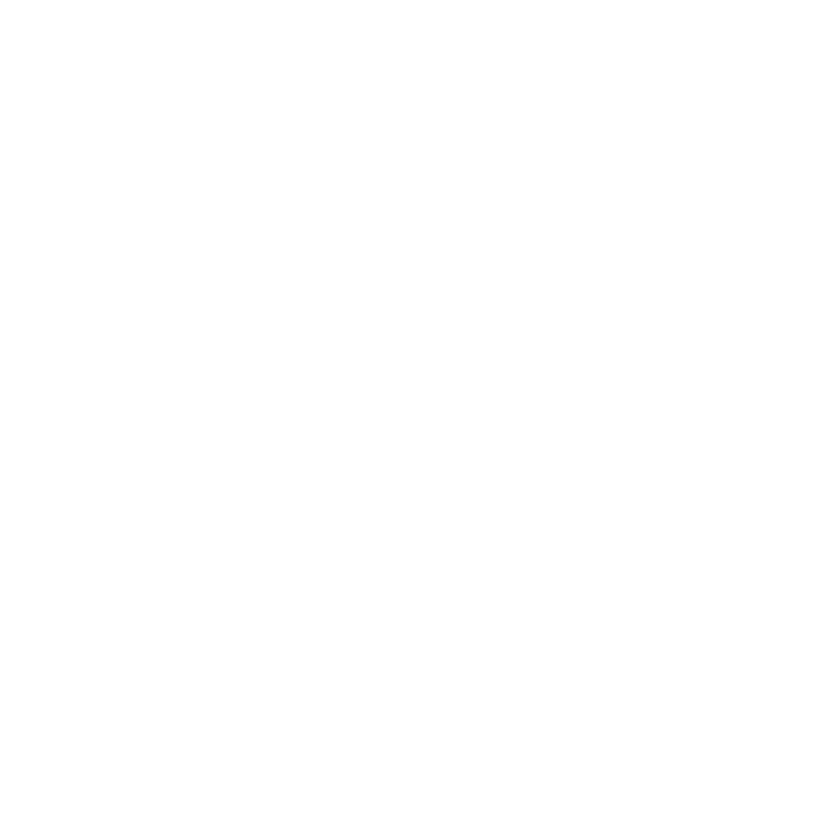

Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
input meRIP input meRIP 
    0     1     0     1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 18 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.719722326596578 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.
Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 1.12719705104828 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 5737 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


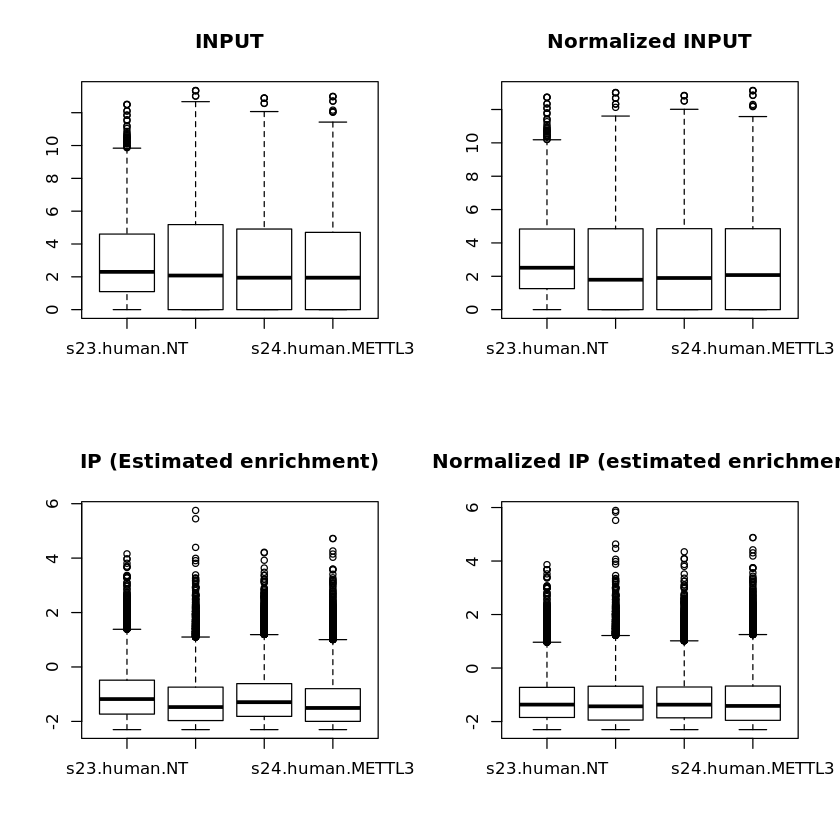

In [58]:
enz = 'METTL3'
run_radar(enz,gtf,'human')

In [ ]:
enz = 'Virma'
run_radar(enz,gtf,'human')

[1] "Stage: index bam file bam/s23.human.Virma.input.bam"
[1] "Stage: index bam file bam/s23.human.Virma.m6A.bam"
[1] "Stage: index bam file bam/s24.human.Virma.input.bam"
[1] "Stage: index bam file bam/s24.human.Virma.m6A.bam"
Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


In [ ]:
enz = 'WTAP'
run_radar(enz,gtf,'human')

# run radar on HIV bam files 

In [24]:
gtf = "HIV/HIV.gtf"

Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... OK


Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 0.0636888424555461 mins... 
Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
input meRIP input meRIP 
    0     1     0     1 
running PoissonGamma test at single beta mode
Hyper-thread registered: FALSE 
Using 1 thread(s) to run PoissonGamma test...


Warning message:
“executing %dopar% sequentially: no parallel backend registered”

Time used to run PoissonGamma test: 0.000761771202087402 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.


ERROR: Error in reportResult(radar, cutoff = cutoff, Beta_cutoff = Beta_cutoff, : There is no bin passing the threshold...
 No differential peaks can be reported at current cutoff...


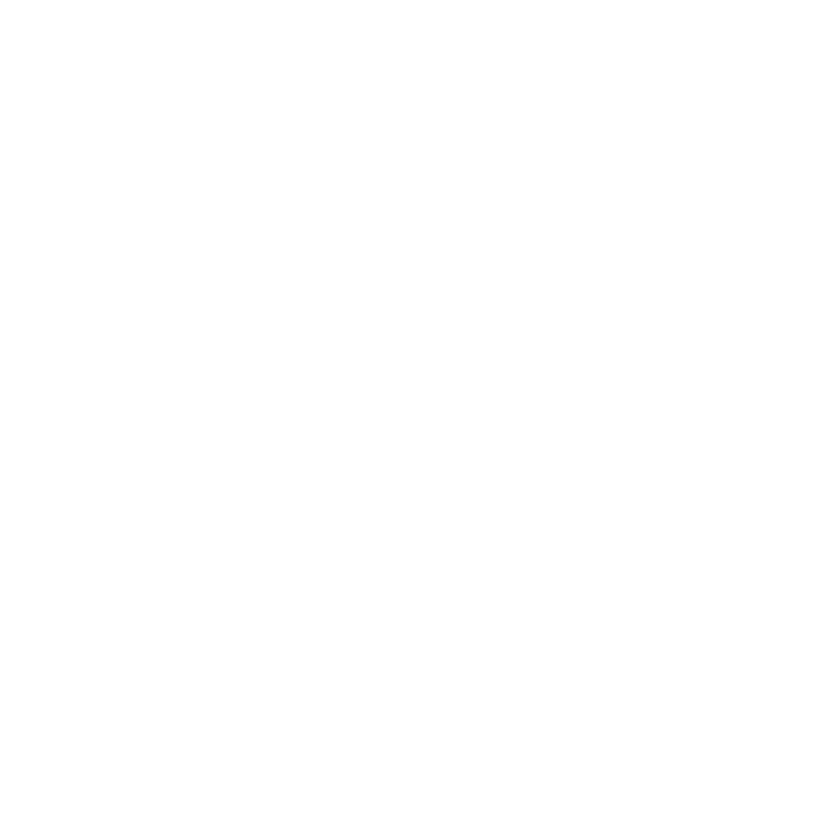

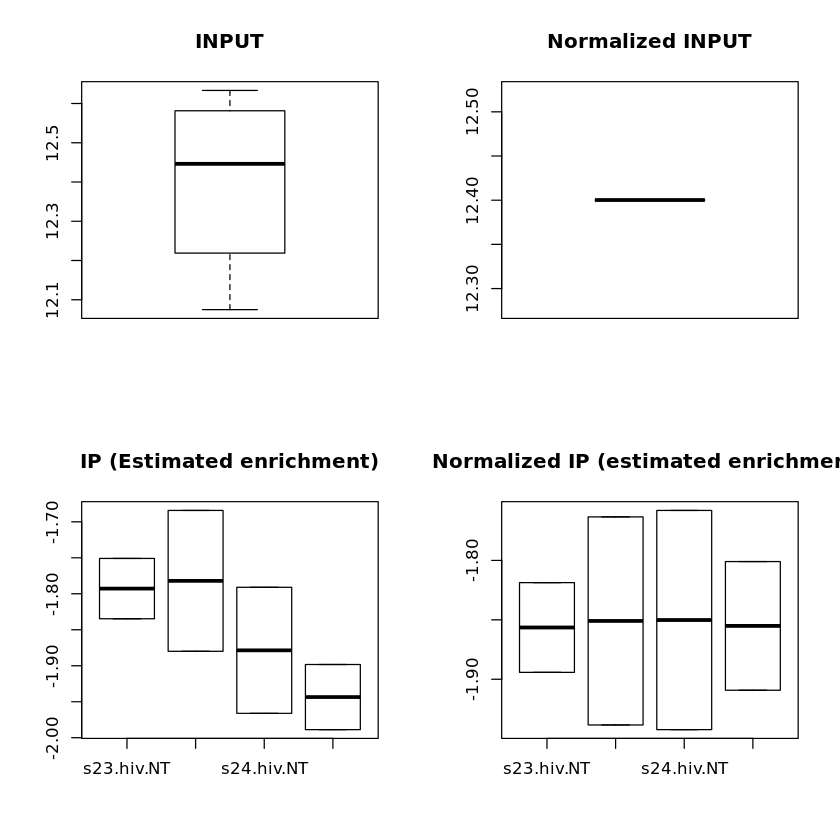

In [48]:
enz = 'METTL14'
run_radar(enz,gtf,'hiv')

Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... OK


Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 0.0675921122233073 mins... 
Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
input meRIP input meRIP 
    0     1     0     1 
running PoissonGamma test at single beta mode
Hyper-thread registered: FALSE 
Using 1 thread(s) to run PoissonGamma test...


Warning message:
“executing %dopar% sequentially: no parallel backend registered”

Time used to run PoissonGamma test: 0.000732052326202393 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.


ERROR: Error in reportResult(radar, cutoff = cutoff, Beta_cutoff = Beta_cutoff, : There is no bin passing the threshold...
 No differential peaks can be reported at current cutoff...


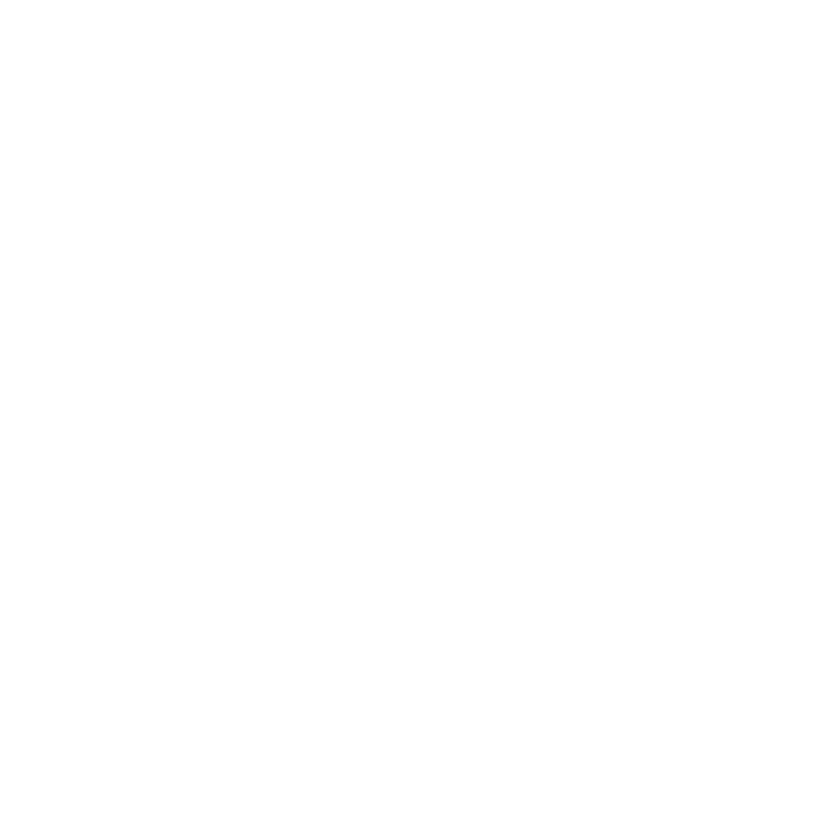

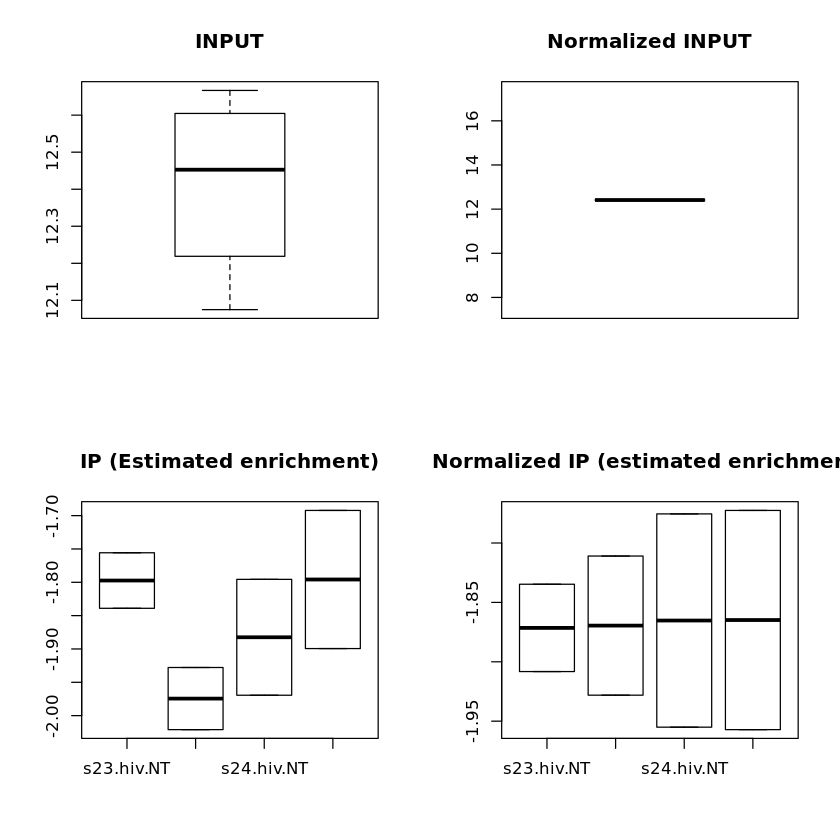

In [49]:
enz = 'METTL3'
run_radar(enz,gtf,'hiv')

Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... OK


Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 0.0635454972585042 mins... 
Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
input meRIP input meRIP 
    0     1     0     1 
running PoissonGamma test at single beta mode
Hyper-thread registered: FALSE 
Using 1 thread(s) to run PoissonGamma test...


Warning message:
“executing %dopar% sequentially: no parallel backend registered”

Time used to run PoissonGamma test: 0.000754415988922119 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.


ERROR: Error in reportResult(radar, cutoff = cutoff, Beta_cutoff = Beta_cutoff, : There is no bin passing the threshold...
 No differential peaks can be reported at current cutoff...


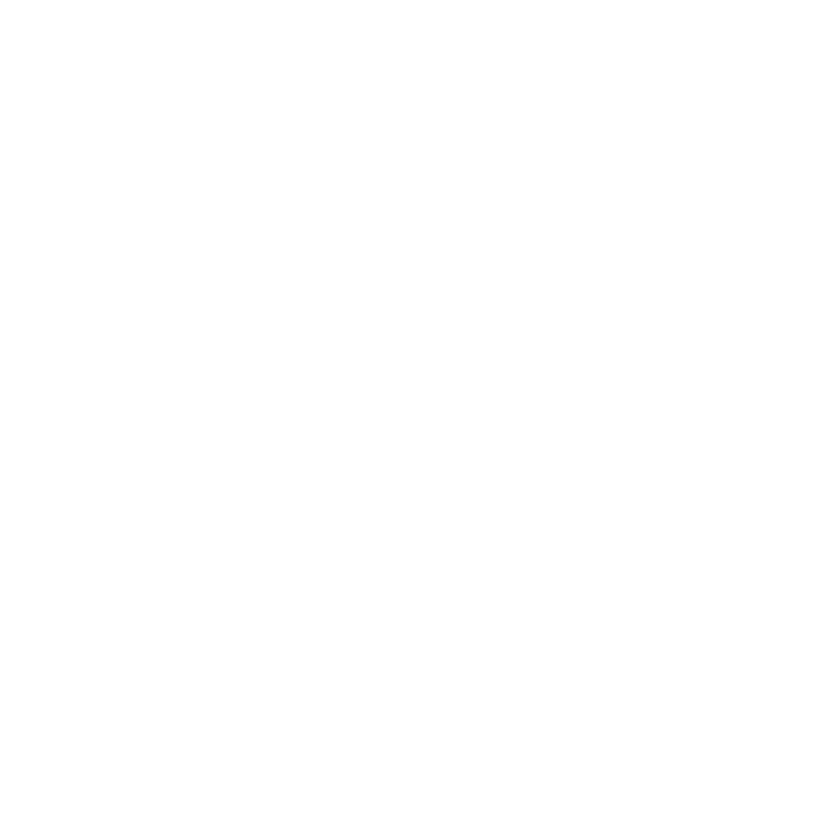

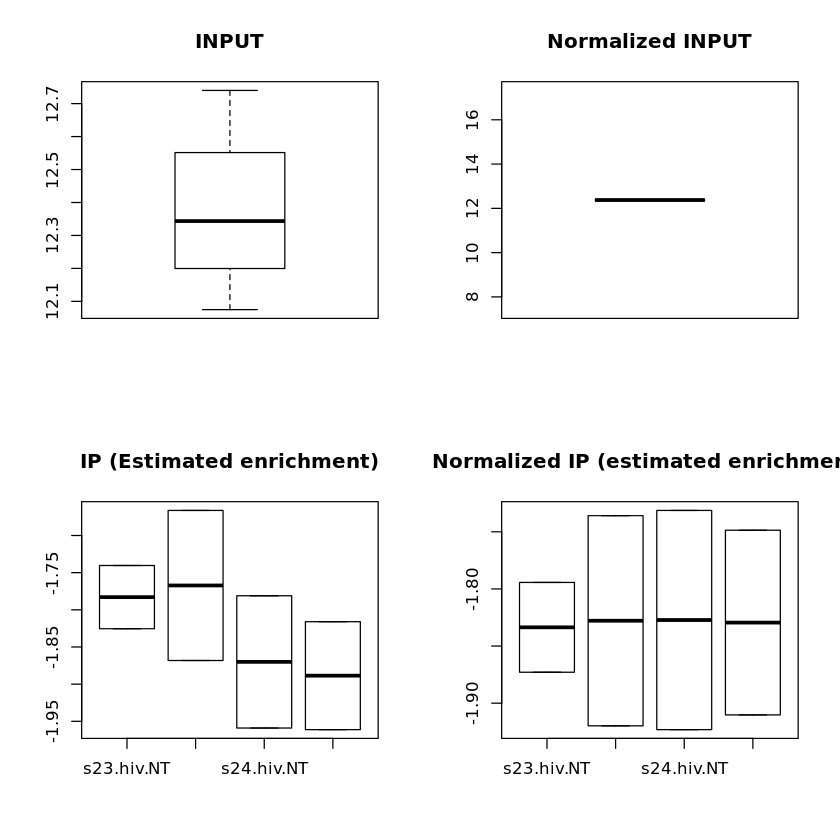

In [50]:
enz = 'Virma'
run_radar(enz,gtf,'hiv')

Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... OK


Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 0.0655012329419454 mins... 
Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
input meRIP input meRIP 
    0     1     0     1 
running PoissonGamma test at single beta mode
Hyper-thread registered: FALSE 
Using 1 thread(s) to run PoissonGamma test...


Warning message:
“executing %dopar% sequentially: no parallel backend registered”

Time used to run PoissonGamma test: 0.000753756364186605 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.


ERROR: Error in reportResult(radar, cutoff = cutoff, Beta_cutoff = Beta_cutoff, : There is no bin passing the threshold...
 No differential peaks can be reported at current cutoff...


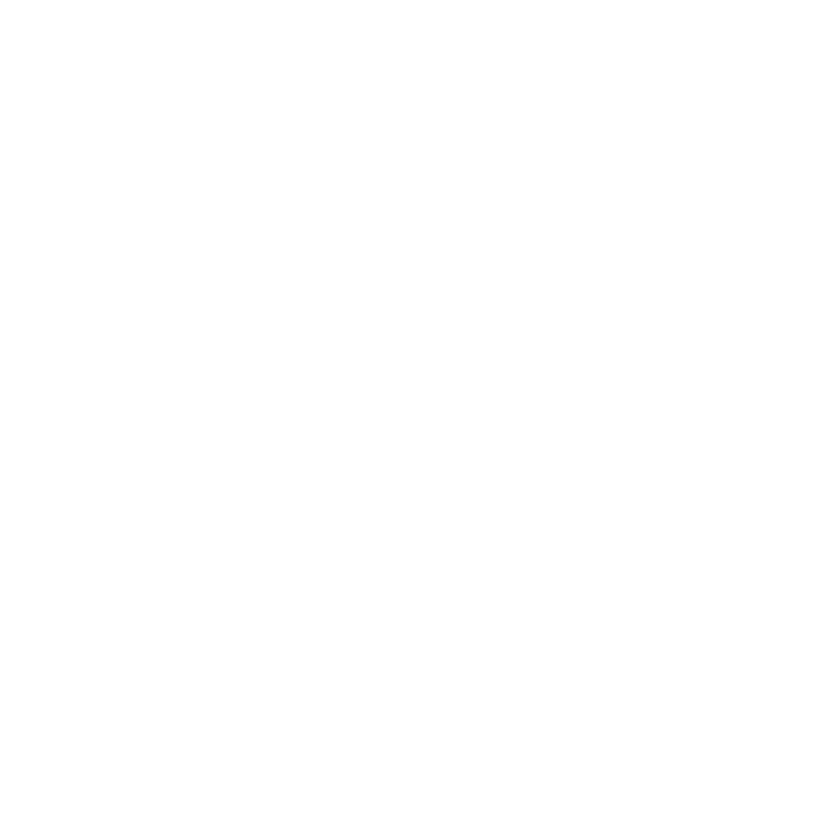

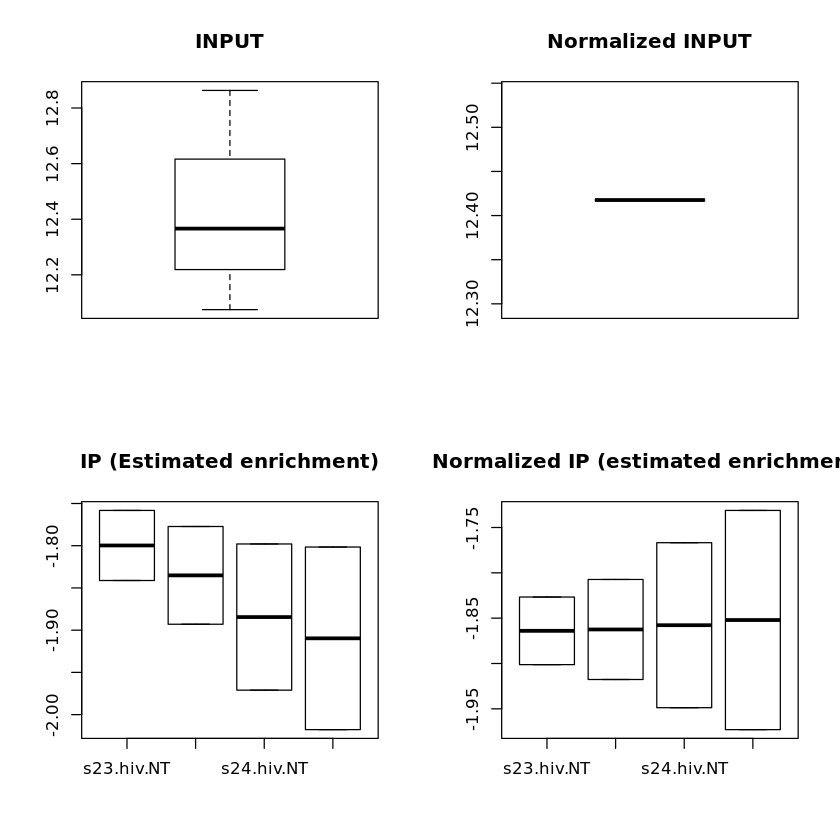

In [51]:
enz = 'WTAP'
run_radar(enz,gtf,'hiv')

In [19]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/RADAR/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] RADAR_0.2.1               qvalue_2.18.0            
 [3] RcppArmadillo_0.9.800.4.0 Rcpp_1.0.3               
 [5] RColorBrewer_1.1-2        gplots_3.0.1.2           
 [7] doParallel_1.0.15         iterators_1.0.12         
 [9] foreach_1.4.7             ggplot2_3.2.1   